In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_25.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

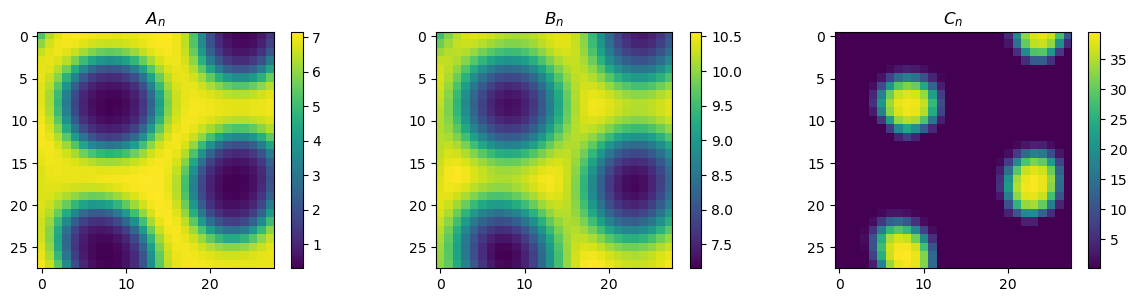

In [4]:
A_n = solution[-1, 0, :, :]
B_n = solution[-1, 1, :, :]
C_n = solution[-1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [5]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
n = 1#params["n"]
tol = .05

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)
n_AA_bound = (1.0, 6.0)
n_AB_bound = (1.0, 6.0)
n_AC_bound = (1.0, 6.0)
n_BA_bound = (1.0, 6.0)
n_BC_bound = (1.0, 6.0)
n_CB_bound = (1.0, 6.0)
n_CC_bound = (1.0, 6.0)

Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC":K_CC_bound}

ns_bounds = {"n_AA":n_AA_bound, 
             "n_AB":n_AB_bound, 
             "n_AC":n_AC_bound,
             "n_BA":n_BA_bound, 
             "n_BC":n_BC_bound,
             "n_CB":n_CB_bound, 
             "n_CC":n_CC_bound}

def closest_bound(name, v):
    if not (name.startswith("K") or name.startswith("n")):
        return np.nan
    if name.startswith("K"):
        lower, upper = Ks_bounds[name]
    else:
        lower, upper = ns_bounds[name]
        
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not (name.startswith("K") or name.startswith("n")):
        return (0, None)
    if name.startswith("K"):
        return Ks_bounds[name]
    else:
        return ns_bounds[name]

Epoch: 1 
 data loss:26.699092, 
data A loss:5.202823, data B loss:9.182021, data C loss:12.314248, 
Laplacian A loss:84.304191, Laplacian B loss:28.041352
Physics loss:1.750050
Negative loss:0.134072

 b_A=0.9000, b_B=0.9000, b_C=0.9000, V_A=1.0000, V_B=1.0000, V_C=1.0000, mu_A=0.9000, mu_B=1.1000, K_AA=1.0000, K_AB=1.0000, K_AC=1.0000, K_BA=1.0000, K_BC=1.0000, K_CB=1.0000, K_CC=1.0000, n_AA=2.0000, n_AB=2.0000, n_AC=2.0000, n_BA=2.0000, n_BC=2.0000, n_CB=2.0000, n_CC=2.0000


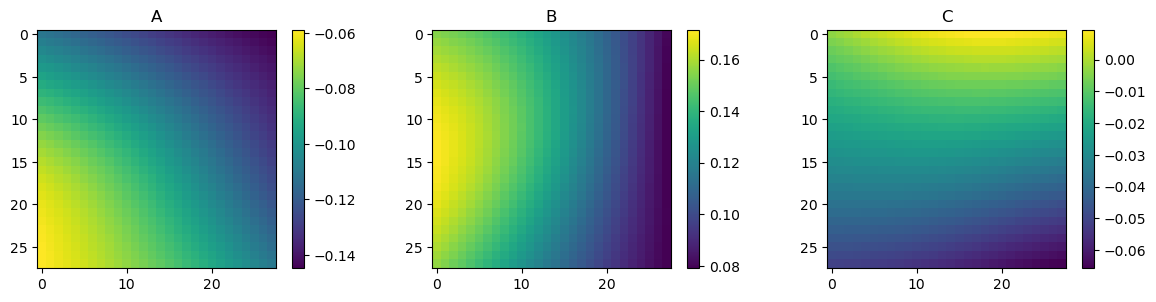

Epoch: 5000 
 data loss:1.497838, 
data A loss:0.134064, data B loss:1.058396, data C loss:0.305378, 
Laplacian A loss:1.967983, Laplacian B loss:26.262706
Physics loss:2.597693
Negative loss:0.043946

 b_A=-0.0167, b_B=156.8887, b_C=0.0730, V_A=13.0844, V_B=27.2310, V_C=64.1505, mu_A=0.9638, mu_B=16.9141, K_AA=4.3475, K_AB=5.5636, K_AC=19.3329, K_BA=16.4707, K_BC=26.5302, K_CB=0.0834, K_CC=78.9042, n_AA=3.9358, n_AB=6.1026, n_AC=4.7776, n_BA=0.9967, n_BC=6.0025, n_CB=6.0066, n_CC=1.2165


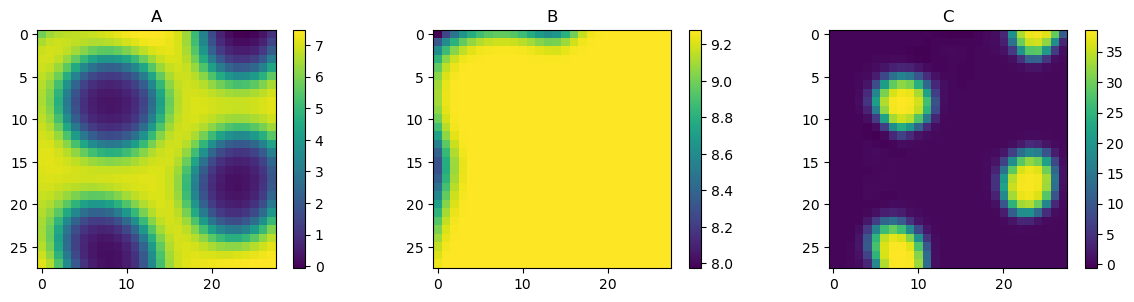

Epoch: 10000 
 data loss:1.155993, 
data A loss:0.072024, data B loss:0.892503, data C loss:0.191466, 
Laplacian A loss:1.031499, Laplacian B loss:17.647363
Physics loss:10.855088
Negative loss:0.031653

 b_A=-0.0101, b_B=-0.0962, b_C=0.0748, V_A=11.5114, V_B=71.0950, V_C=80.8256, mu_A=0.9420, mu_B=1.3270, K_AA=4.3590, K_AB=6.3927, K_AC=7.1109, K_BA=23.1976, K_BC=28.9645, K_CB=0.2362, K_CC=105.7407, n_AA=4.0270, n_AB=3.3271, n_AC=6.0832, n_BA=0.9996, n_BC=5.3416, n_CB=2.4398, n_CC=1.1625


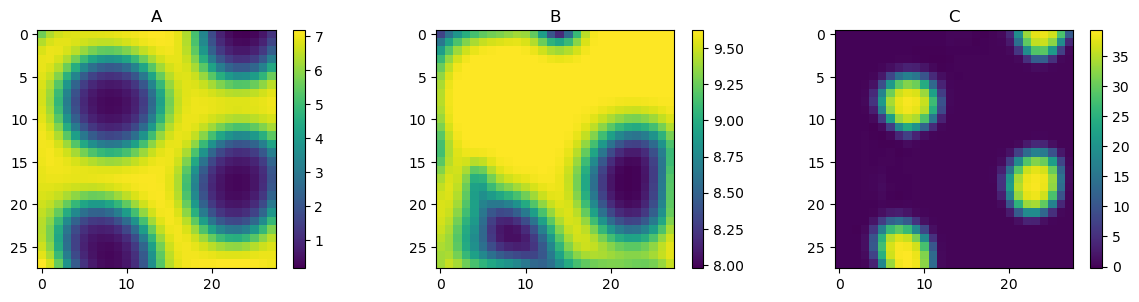

Epoch: 15000 
 data loss:1.174788, 
data A loss:0.056021, data B loss:0.972408, data C loss:0.146359, 
Laplacian A loss:0.565492, Laplacian B loss:13.559367
Physics loss:12.557419
Negative loss:0.018661

 b_A=-0.0109, b_B=-0.0888, b_C=0.0668, V_A=10.4793, V_B=85.8436, V_C=90.0044, mu_A=0.9331, mu_B=1.7507, K_AA=4.3613, K_AB=6.7750, K_AC=6.8236, K_BA=32.3225, K_BC=29.1573, K_CB=0.2436, K_CC=121.1299, n_AA=4.0646, n_AB=3.1835, n_AC=6.0717, n_BA=1.0021, n_BC=5.6514, n_CB=6.0167, n_CC=1.1497


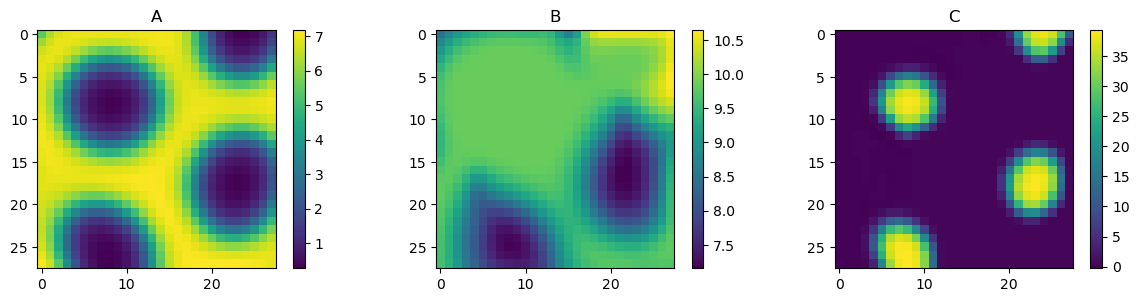

Epoch: 20000 
 data loss:0.582960, 
data A loss:0.039594, data B loss:0.425218, data C loss:0.118148, 
Laplacian A loss:0.396264, Laplacian B loss:1.805448
Physics loss:4.951407
Negative loss:0.016980

 b_A=-0.0071, b_B=-0.0315, b_C=0.0753, V_A=9.5527, V_B=98.2440, V_C=96.7879, mu_A=0.9330, mu_B=4.0275, K_AA=4.3965, K_AB=5.0340, K_AC=6.4757, K_BA=35.7845, K_BC=28.4811, K_CB=0.5208, K_CC=132.1568, n_AA=4.0399, n_AB=3.9819, n_AC=6.0677, n_BA=1.3652, n_BC=4.2046, n_CB=1.7526, n_CC=1.1357


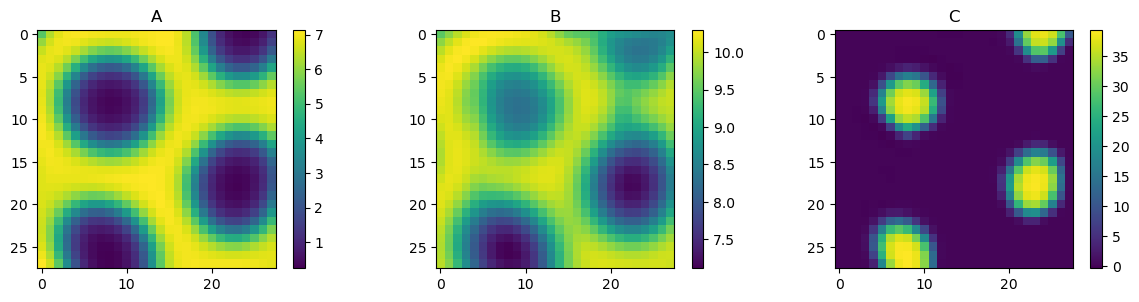

Epoch: 25000 
 data loss:0.287976, 
data A loss:0.034747, data B loss:0.191293, data C loss:0.061936, 
Laplacian A loss:0.315852, Laplacian B loss:0.626463
Physics loss:2.216055
Negative loss:0.004488

 b_A=-0.0056, b_B=-0.0078, b_C=0.0697, V_A=11.1879, V_B=104.6066, V_C=102.2376, mu_A=0.9436, mu_B=4.6114, K_AA=4.5451, K_AB=5.1836, K_AC=7.2317, K_BA=16.2598, K_BC=26.7288, K_CB=1.6103, K_CC=140.2875, n_AA=3.9049, n_AB=3.7796, n_AC=6.0210, n_BA=2.3830, n_BC=3.4105, n_CB=1.3171, n_CC=1.1260


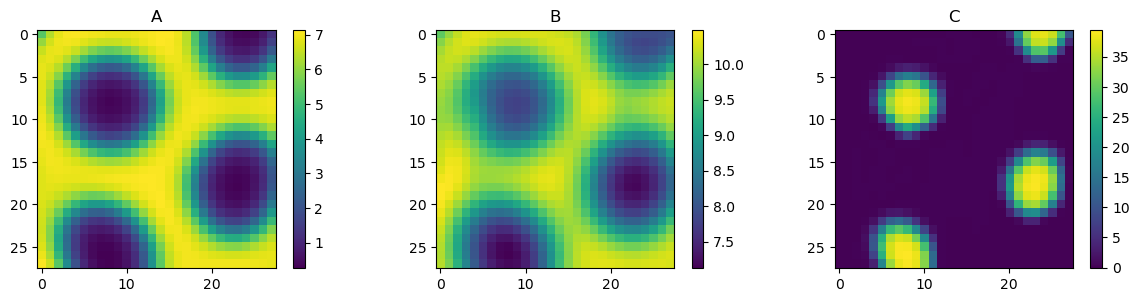

Epoch: 30000 
 data loss:0.107801, 
data A loss:0.033029, data B loss:0.044366, data C loss:0.030406, 
Laplacian A loss:0.281165, Laplacian B loss:0.194257
Physics loss:0.901286
Negative loss:0.000516

 b_A=-0.0027, b_B=0.0084, b_C=0.0588, V_A=15.7562, V_B=108.6552, V_C=109.3095, mu_A=0.9884, mu_B=4.9020, K_AA=5.3073, K_AB=5.2659, K_AC=8.0966, K_BA=11.4278, K_BC=20.9462, K_CB=5.9141, K_CC=144.2809, n_AA=3.3834, n_AB=3.5097, n_AC=6.0074, n_BA=6.0020, n_BC=2.5365, n_CB=1.3307, n_CC=1.1142


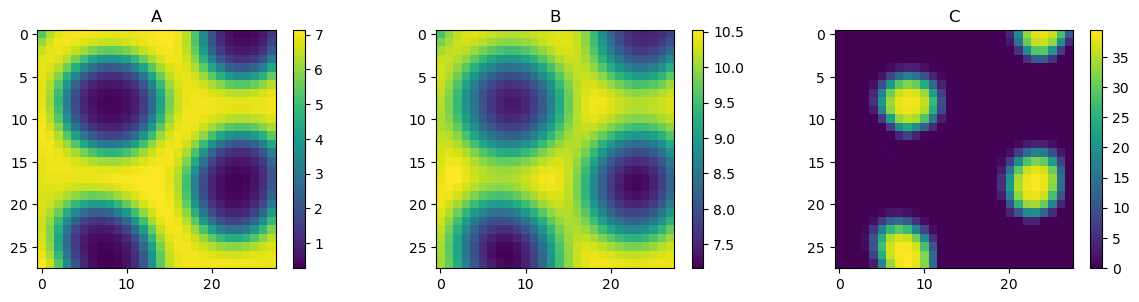

Epoch: 35000 
 data loss:0.081112, 
data A loss:0.038474, data B loss:0.021071, data C loss:0.021567, 
Laplacian A loss:0.999562, Laplacian B loss:0.172029
Physics loss:0.754299
Negative loss:0.000000

 b_A=0.0068, b_B=0.3220, b_C=0.0569, V_A=17.0512, V_B=109.5152, V_C=115.9222, mu_A=0.9996, mu_B=5.0014, K_AA=5.4510, K_AB=5.2731, K_AC=9.3725, K_BA=11.2921, K_BC=13.8415, K_CB=10.8574, K_CC=146.0568, n_AA=3.2990, n_AB=3.4539, n_AC=5.9821, n_BA=5.9753, n_BC=3.0618, n_CB=1.6667, n_CC=1.0911


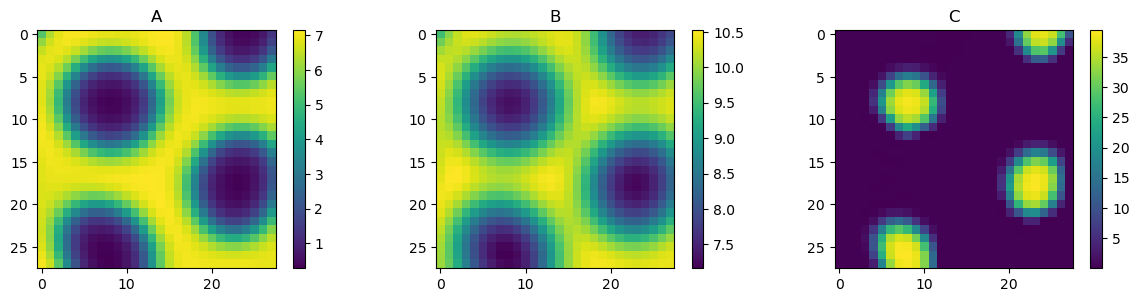

Epoch: 40000 
 data loss:0.062114, 
data A loss:0.031888, data B loss:0.015748, data C loss:0.014478, 
Laplacian A loss:0.289604, Laplacian B loss:0.084128
Physics loss:0.470946
Negative loss:0.000000

 b_A=0.0078, b_B=0.6408, b_C=0.0439, V_A=17.4898, V_B=109.9899, V_C=118.6509, mu_A=1.0105, mu_B=5.0588, K_AA=5.4967, K_AB=5.2809, K_AC=12.2313, K_BA=11.2413, K_BC=11.8692, K_CB=13.0498, K_CC=148.6261, n_AA=3.2744, n_AB=3.4478, n_AC=5.9879, n_BA=6.0020, n_BC=3.6681, n_CB=1.6989, n_CC=1.0819


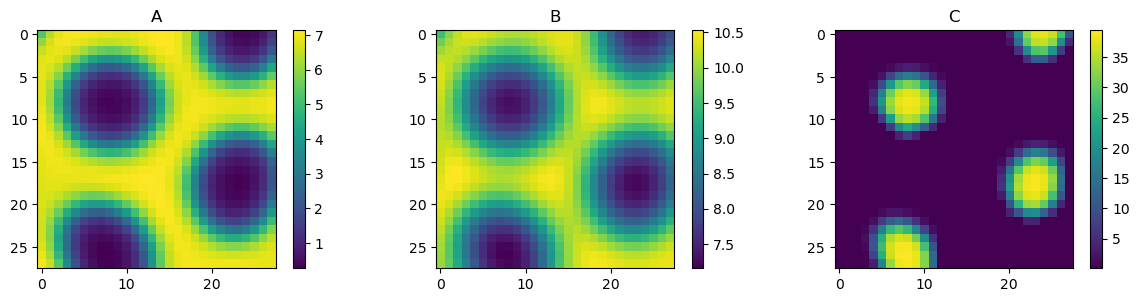

Epoch: 45000 
 data loss:0.066014, 
data A loss:0.031483, data B loss:0.013225, data C loss:0.021306, 
Laplacian A loss:0.222956, Laplacian B loss:0.069911
Physics loss:0.402605
Negative loss:0.000000

 b_A=0.0086, b_B=0.8819, b_C=0.0439, V_A=17.6800, V_B=110.2745, V_C=119.8779, mu_A=1.0164, mu_B=5.0957, K_AA=5.5181, K_AB=5.2859, K_AC=12.9009, K_BA=11.2290, K_BC=11.7722, K_CB=13.7580, K_CC=151.5426, n_AA=3.2595, n_AB=3.4424, n_AC=6.0013, n_BA=6.0005, n_BC=3.7821, n_CB=1.7789, n_CC=1.0780


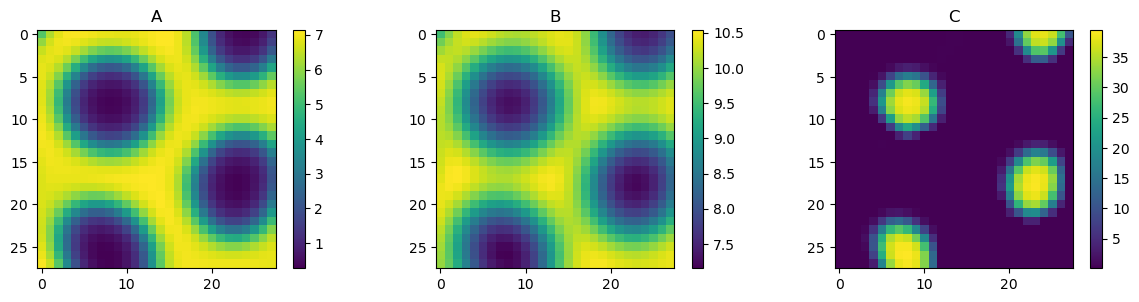

Epoch: 50000 
 data loss:0.066539, 
data A loss:0.031284, data B loss:0.011739, data C loss:0.023516, 
Laplacian A loss:0.214619, Laplacian B loss:0.055613
Physics loss:0.366864
Negative loss:0.000000

 b_A=0.0089, b_B=1.0740, b_C=0.0414, V_A=17.7748, V_B=110.5133, V_C=121.0180, mu_A=1.0185, mu_B=5.1237, K_AA=5.5288, K_AB=5.2896, K_AC=12.9682, K_BA=11.2223, K_BC=11.7628, K_CB=14.4861, K_CC=154.2164, n_AA=3.2527, n_AB=3.4378, n_AC=6.0003, n_BA=5.9999, n_BC=3.8458, n_CB=1.7944, n_CC=1.0782


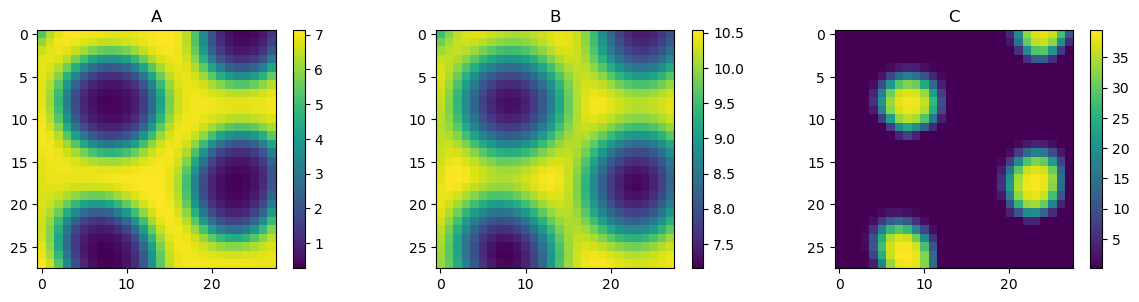

Epoch: 55000 
 data loss:0.050100, 
data A loss:0.030977, data B loss:0.010823, data C loss:0.008300, 
Laplacian A loss:0.194879, Laplacian B loss:0.049175
Physics loss:0.338890
Negative loss:0.000000

 b_A=0.0100, b_B=1.2284, b_C=0.0431, V_A=17.8174, V_B=110.7096, V_C=122.1145, mu_A=1.0194, mu_B=5.1447, K_AA=5.5330, K_AB=5.2921, K_AC=13.1077, K_BA=11.2234, K_BC=11.7794, K_CB=15.0506, K_CC=156.6563, n_AA=3.2491, n_AB=3.4319, n_AC=6.0012, n_BA=6.0007, n_BC=3.8896, n_CB=1.7943, n_CC=1.0747


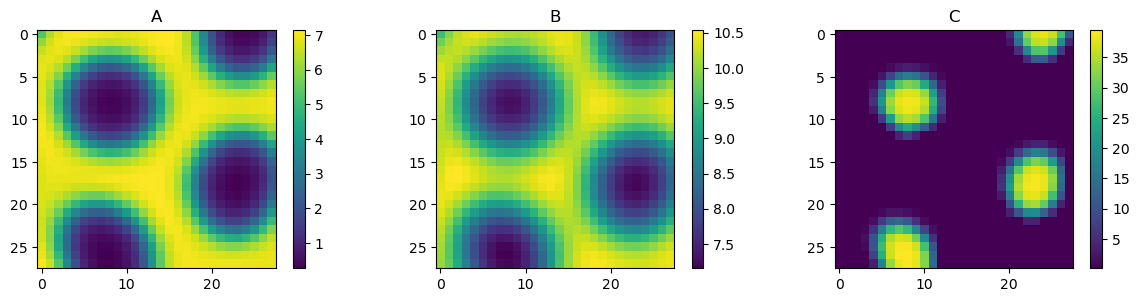

Epoch: 60000 
 data loss:0.050143, 
data A loss:0.030763, data B loss:0.010139, data C loss:0.009241, 
Laplacian A loss:0.184221, Laplacian B loss:0.045233
Physics loss:0.320528
Negative loss:0.000000

 b_A=0.0100, b_B=1.3647, b_C=0.0435, V_A=17.8445, V_B=110.8719, V_C=123.1957, mu_A=1.0199, mu_B=5.1635, K_AA=5.5362, K_AB=5.2945, K_AC=13.4951, K_BA=11.2227, K_BC=11.7980, K_CB=15.5520, K_CC=158.9346, n_AA=3.2468, n_AB=3.4286, n_AC=6.0018, n_BA=6.0008, n_BC=3.9190, n_CB=1.7921, n_CC=1.0725


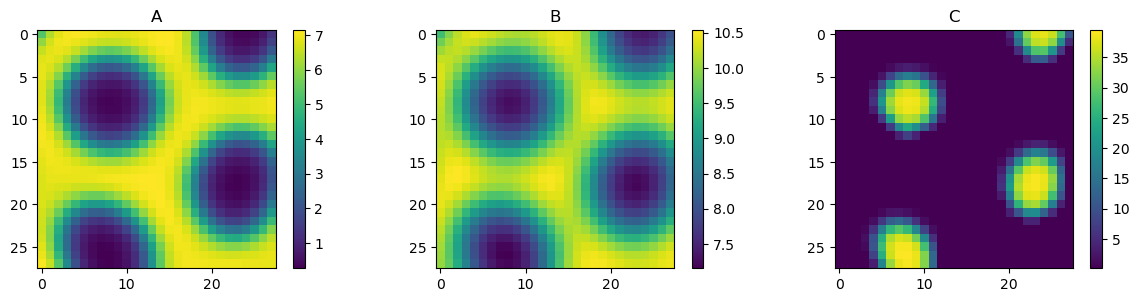

Epoch: 65000 
 data loss:0.056514, 
data A loss:0.030601, data B loss:0.009595, data C loss:0.016317, 
Laplacian A loss:0.178399, Laplacian B loss:0.043239
Physics loss:0.307620
Negative loss:0.000000

 b_A=0.0096, b_B=1.4874, b_C=0.0419, V_A=17.8558, V_B=111.0139, V_C=124.2479, mu_A=1.0204, mu_B=5.1807, K_AA=5.5384, K_AB=5.2969, K_AC=13.9702, K_BA=11.2230, K_BC=11.8269, K_CB=16.0177, K_CC=161.0963, n_AA=3.2450, n_AB=3.4255, n_AC=5.9796, n_BA=6.0002, n_BC=3.9325, n_CB=1.7851, n_CC=1.0726


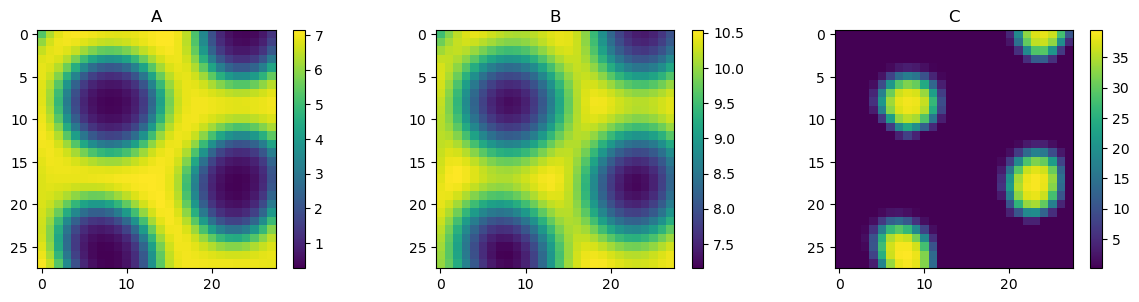

Epoch: 70000 
 data loss:0.053658, 
data A loss:0.030748, data B loss:0.009427, data C loss:0.013483, 
Laplacian A loss:0.303026, Laplacian B loss:0.050762
Physics loss:0.329790
Negative loss:0.000000

 b_A=0.0106, b_B=1.5965, b_C=0.0413, V_A=17.8654, V_B=111.1524, V_C=125.2908, mu_A=1.0181, mu_B=5.1942, K_AA=5.5387, K_AB=5.2969, K_AC=14.5579, K_BA=11.2251, K_BC=11.8550, K_CB=16.6209, K_CC=163.1404, n_AA=3.2450, n_AB=3.4201, n_AC=6.0004, n_BA=6.0013, n_BC=3.9454, n_CB=1.8512, n_CC=1.0720


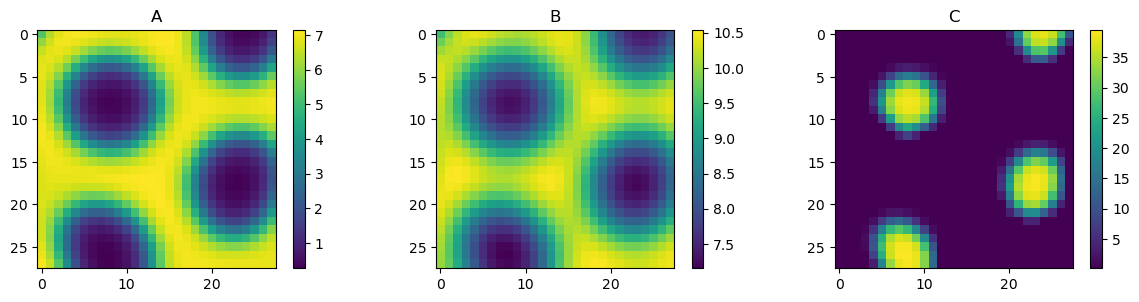

Epoch: 75000 
 data loss:0.045553, 
data A loss:0.030185, data B loss:0.008925, data C loss:0.006443, 
Laplacian A loss:0.157688, Laplacian B loss:0.038851
Physics loss:0.287003
Negative loss:0.000000

 b_A=0.0093, b_B=1.6926, b_C=0.0416, V_A=17.8684, V_B=111.2669, V_C=126.2980, mu_A=1.0203, mu_B=5.2087, K_AA=5.5401, K_AB=5.3005, K_AC=15.2291, K_BA=11.2234, K_BC=11.8812, K_CB=16.9700, K_CC=165.0819, n_AA=3.2435, n_AB=3.4190, n_AC=6.0014, n_BA=6.0008, n_BC=3.9482, n_CB=1.7637, n_CC=1.0700


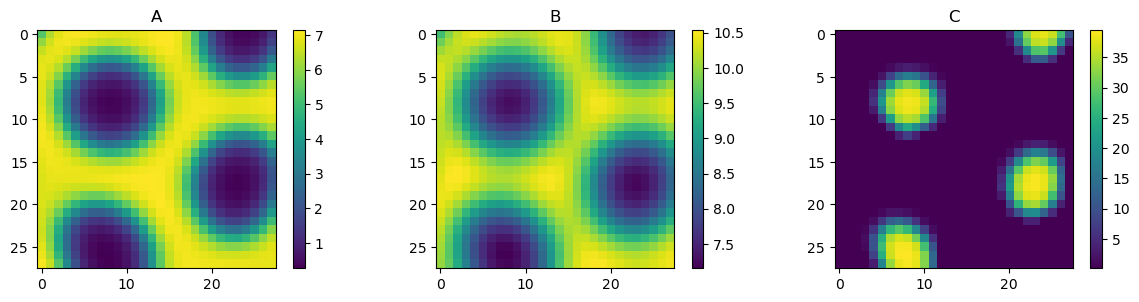

Epoch: 80000 
 data loss:0.048708, 
data A loss:0.032753, data B loss:0.009484, data C loss:0.006471, 
Laplacian A loss:0.599075, Laplacian B loss:0.099087
Physics loss:0.450141
Negative loss:0.000000

 b_A=0.0070, b_B=1.7762, b_C=0.0496, V_A=17.8709, V_B=111.3720, V_C=127.2866, mu_A=1.0156, mu_B=5.2181, K_AA=5.5444, K_AB=5.2999, K_AC=15.9181, K_BA=11.2312, K_BC=11.9265, K_CB=17.4853, K_CC=166.9143, n_AA=3.2392, n_AB=3.4137, n_AC=5.9842, n_BA=5.9799, n_BC=3.9635, n_CB=1.7885, n_CC=1.0628


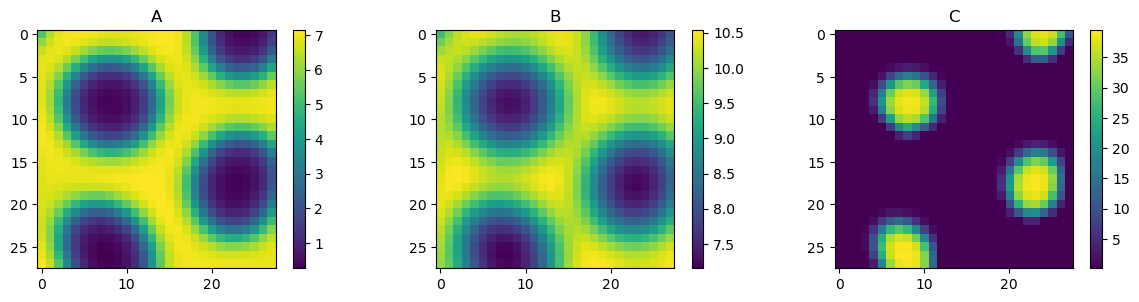

Epoch: 85000 
 data loss:0.045948, 
data A loss:0.030121, data B loss:0.008592, data C loss:0.007236, 
Laplacian A loss:0.219909, Laplacian B loss:0.052889
Physics loss:0.299434
Negative loss:0.000000

 b_A=0.0076, b_B=1.8486, b_C=0.0435, V_A=17.8642, V_B=111.4504, V_C=128.2176, mu_A=1.0194, mu_B=5.2305, K_AA=5.5428, K_AB=5.3036, K_AC=16.5731, K_BA=11.2295, K_BC=11.9596, K_CB=17.7962, K_CC=168.6896, n_AA=3.2397, n_AB=3.4144, n_AC=5.9857, n_BA=5.9820, n_BC=3.9538, n_CB=1.7861, n_CC=1.0669


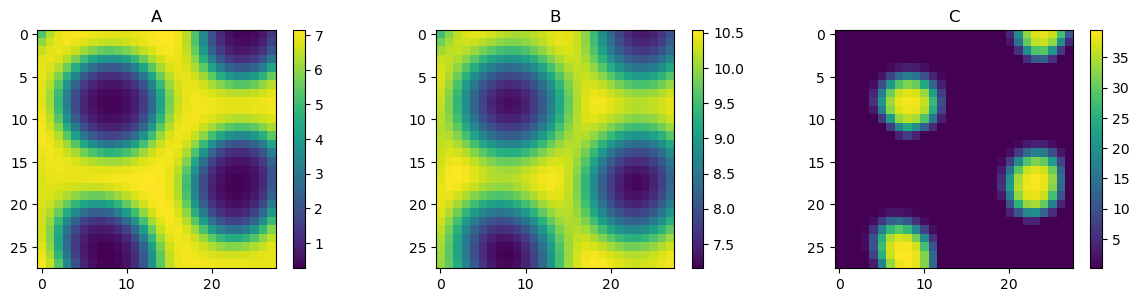

Epoch: 90000 
 data loss:0.052027, 
data A loss:0.029818, data B loss:0.008286, data C loss:0.013923, 
Laplacian A loss:0.134158, Laplacian B loss:0.035537
Physics loss:0.268876
Negative loss:0.000000

 b_A=0.0083, b_B=1.9170, b_C=0.0402, V_A=17.8641, V_B=111.5335, V_C=129.1330, mu_A=1.0201, mu_B=5.2399, K_AA=5.5409, K_AB=5.3046, K_AC=17.2479, K_BA=11.2249, K_BC=11.9767, K_CB=18.2548, K_CC=170.4024, n_AA=3.2427, n_AB=3.4127, n_AC=6.0010, n_BA=6.0006, n_BC=3.9389, n_CB=1.7328, n_CC=1.0681


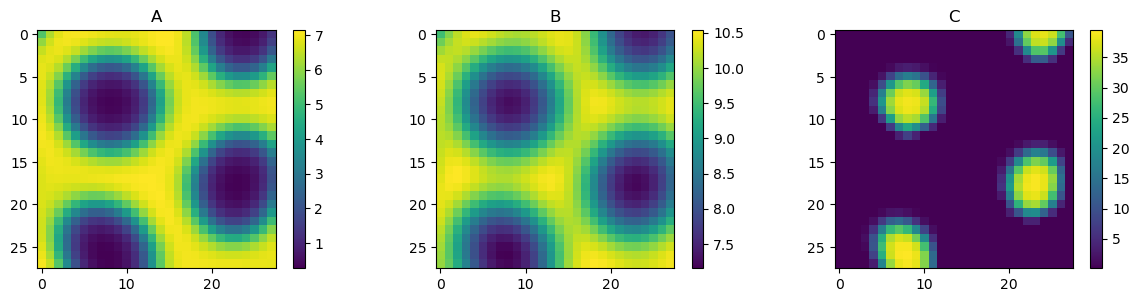

Epoch: 95000 
 data loss:0.043555, 
data A loss:0.031173, data B loss:0.008149, data C loss:0.004233, 
Laplacian A loss:0.379383, Laplacian B loss:0.080195
Physics loss:0.341381
Negative loss:0.000000

 b_A=0.0045, b_B=1.9746, b_C=0.0383, V_A=17.8635, V_B=111.6005, V_C=130.0307, mu_A=1.0230, mu_B=5.2522, K_AA=5.5448, K_AB=5.3093, K_AC=17.8815, K_BA=11.2197, K_BC=12.0011, K_CB=18.6617, K_CC=172.0395, n_AA=3.2393, n_AB=3.4107, n_AC=6.0006, n_BA=5.9943, n_BC=3.9325, n_CB=1.7209, n_CC=1.0689


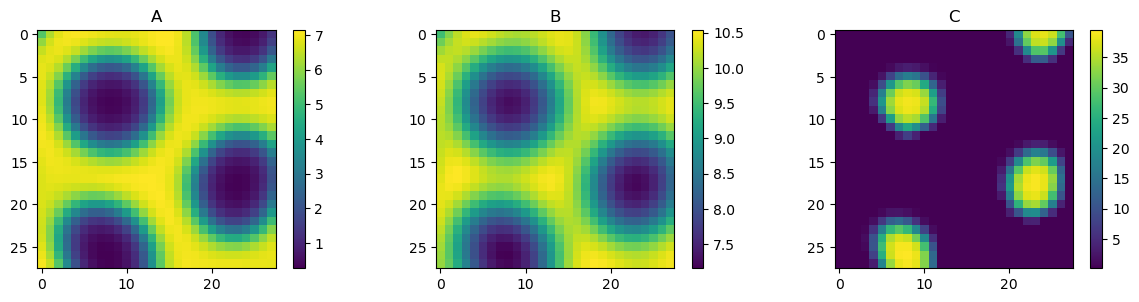

Epoch: 100000 
 data loss:0.045158, 
data A loss:0.029629, data B loss:0.008042, data C loss:0.007487, 
Laplacian A loss:0.121136, Laplacian B loss:0.033886
Physics loss:0.261036
Negative loss:0.000000

 b_A=0.0082, b_B=2.0259, b_C=0.0395, V_A=17.8557, V_B=111.6554, V_C=130.8714, mu_A=1.0202, mu_B=5.2549, K_AA=5.5405, K_AB=5.3062, K_AC=18.4303, K_BA=11.2286, K_BC=12.0427, K_CB=18.8622, K_CC=173.6015, n_AA=3.2419, n_AB=3.4098, n_AC=6.0008, n_BA=6.0007, n_BC=3.9239, n_CB=1.7254, n_CC=1.0669


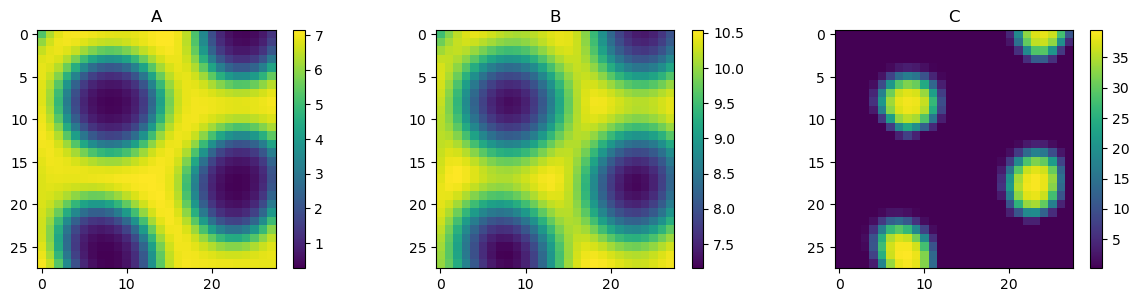

    Early dtoped at 100003
Epoch: 100003 
 data loss:0.043584, 
data A loss:0.029633, data B loss:0.008039, data C loss:0.005911, 
Laplacian A loss:0.120702, Laplacian B loss:0.033895
Physics loss:0.260839
Negative loss:0.000000

 b_A=0.0082, b_B=2.0260, b_C=0.0397, V_A=17.8560, V_B=111.6556, V_C=130.8726, mu_A=1.0202, mu_B=5.2549, K_AA=5.5405, K_AB=5.3062, K_AC=18.4309, K_BA=11.2284, K_BC=12.0428, K_CB=18.8661, K_CC=173.6026, n_AA=3.2420, n_AB=3.4097, n_AC=6.0008, n_BA=6.0007, n_BC=3.9242, n_CB=1.7252, n_CC=1.0667


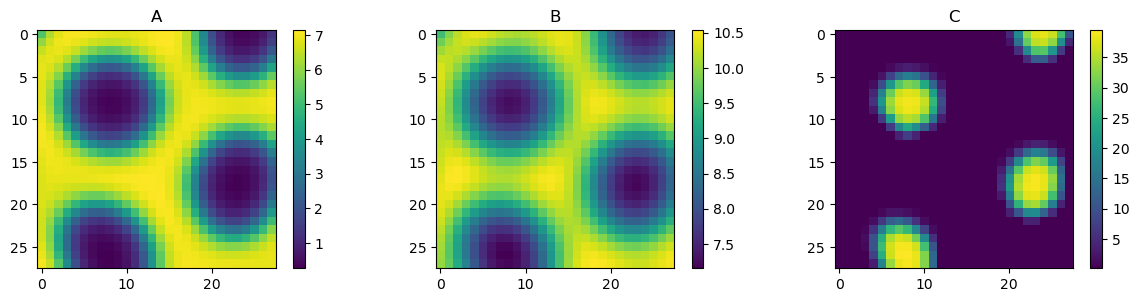

In [6]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str)), []
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str)), []


D_A=params["D_A"]#, sampled_D_A = create_var()
D_B=params["D_B"]#, sampled_D_B = create_var()
b_A, sampled_b_A = create_var(1)
b_B, sampled_b_B = create_var(1)
b_C, sampled_b_C = create_var(1)
V_A, sampled_V_A = create_var(1)
V_B, sampled_V_B = create_var(1)
V_C, sampled_V_C = create_var(1)
mu_A, sampled_mu_A = create_var(1)
mu_B, sampled_mu_B = create_var(1)
mu_C=params["mu_C"]#, sampled_mu_C = create_var()
K_AA, sampled_K_AA = create_var(1)#K_AA_init)
K_AB, sampled_K_AB = create_var(1)#K_AB_init)
K_AC, sampled_K_AC = create_var(1)#K_AC_init)
K_BA, sampled_K_BA = create_var(1)#K_BA_init)
K_BC, sampled_K_BC = create_var(1)#K_BC_init)
K_CB, sampled_K_CB = create_var(1)#K_CB_init)
K_CC, sampled_K_CC = create_var(1)#K_CC_init)
n_AA, sampled_n_AA = create_var(2)#= params['n']
n_AB, sampled_n_AB = create_var(2)#= params['n']
n_AC, sampled_n_AC = create_var(2)#= params['n']
n_BA, sampled_n_BA = create_var(2)#= params['n']
n_BC, sampled_n_BC = create_var(2)#= params['n']
n_CB, sampled_n_CB = create_var(2)#= params['n']
n_CC, sampled_n_CC = create_var(2)#= params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC", 
                     "n_AA", "n_AB", "n_AC",
                     "n_BA", "n_BC",
                     "n_CB", "n_CC",
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC, 
               n_AA, n_AB, n_AC, n_BA, n_BC,
               n_CB, n_CC
]

params_sampled_list =[#sampled_D_A, sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, #sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC,
                      sampled_n_AA, sampled_n_AB, sampled_n_AC,
                      sampled_n_BA, sampled_n_BC, 
                      sampled_n_CB, sampled_n_CC,
                     ]

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

def transform(x, l, u):
    return (u-l)*x + l

x2 = transform(torch.rand(run_params.Ix),torch.min(x).item(),torch.max(x).item())
y2 = transform(torch.rand(run_params.Jy),torch.min(y).item(),torch.max(y).item())
X2,Y2 = torch.meshgrid(x2, y2, indexing='ij')
physics_X = torch.vstack([X2.flatten(), Y2.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[128,128,128,128], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-4},
                              {'params': params_list, 'lr': .1},
                              #{'params': [n], 'lr': 0.5}
                             ]
                              , lr=1e-4)#.LBFGS([*model.parameters(), *params_list], lr=1
                             #,line_search_fn='strong_wolfe')#


epochs = 100000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics = 1e-3
loss_laplacian_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((7, epochs + 6000))
last_loss = np.inf

negative_threshold = nn.Threshold(0.0, 0.0)

def act_t(x, km, n=2):
    return negative_threshold(x)**n / (negative_threshold(x)**n + km**n)

def inh_t(x, km, n=2):
    return km**n / (negative_threshold(x)**n + km**n)

for i in range(epochs + 6000): 
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # Laplacians derivatives        
        laplacianA_hat = Laplacian(data_A_hat, data_X)
        laplacianB_hat = Laplacian(data_B_hat, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        # physics derivatives  
        physics_f_hat = model(physics_X)
        A = physics_f_hat[0].squeeze() 
        B = physics_f_hat[1].squeeze() 
        C = physics_f_hat[2].squeeze() 
        
        laplacianA_hat = Laplacian(A, physics_X)
        laplacianB_hat = Laplacian(B, physics_X)
        
        F_A =  b_A + V_A*act_t(A, K_AA, n_AA)*inh_t(B, K_BA, n_BA) - mu_A * A    
        F_B =  b_B + V_B*act_t(A, K_AB, n_AB)*inh_t(C, K_CB, n_CB) - mu_B * B        
        F_C =  b_C + V_C*inh_t(A, K_AC, n_AC)*inh_t(B, K_BC, n_BC)*act_t(C, K_CC, n_CC) - mu_C * C        

        dAdt = D_A * laplacianA_hat + F_A
        dBdt = D_B * laplacianB_hat + F_B
        dCdt = F_C
        ################################
        # physics loss
        # Construct the physics loss here
        A_loss_physics = torch.mean(dAdt**2)
        B_loss_physics = torch.mean(dBdt**2)
        C_loss_physics = torch.mean(dCdt**2)
        loss_physics = (A_loss_physics  
                        + B_loss_physics 
                        + C_loss_physics)
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            +lambda_physics*loss_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_physics.item(), loss_negative.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
    
    def show_outputs(i):
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Physics loss:{ls[5]:.6f}\n"
              f"Negative loss:{ls[6]:.6f}\n"
              f"\n"
              ,
              ", ".join([f"{name}={param.item():.4f}" for param, name in zip(params_list, params_name_list)])
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show()
       
    
    if i < epochs and last_loss > np.sum(losses[:,i]):
        last_loss =  np.sum(losses[:,i])
            
    elif np.sum(losses[:,i]) < last_loss:
        print("============================================")
        print(f"    Early dtoped at {i+1}")
        print("============================================")
        show_outputs(i)
        early_stop = True
        with torch.no_grad():
            for i,(param, name) in enumerate(zip(params_list, params_name_list)):
                l,u = get_bound(name)
                param[:] = param.clamp(l,u)
                params_sampled_list[i].append(param.item())
        break        
    
    if (i+1)%5000 == 0 or i==0:        
        show_outputs(i)
        
    with torch.no_grad():
        for i,(param, name) in enumerate(zip(params_list, params_name_list)):
#             if name == "n":
#                 closest_int = np.rint(param.item())
#                 if closest_int < n_bound[0]:
#                     closest_int = n_bound[0]
#                 elif closest_int > n_bound[1]:
#                     closest_int = n_bound[1]
#                 param[:] = closest_int
#                 params_sampled_list[i].append(param.item())
#             else:
            l,u = get_bound(name)
            param[:] = param.clamp(l,u)
            params_sampled_list[i].append(param.item())
            


# Plot the trained outputs

A RMSE:0.029636867358043145 B RMSE:0.008041132387307769 C RMSE:0.005732462092735889
F_A actual:0.8813861277557233, F_A:0.8805846571922302, RMSE: 0.019312428624787076
F_B actual:819.2497758940649, F_B:810.4523315429688, RMSE: 0.3126749739782781
F_C actual:0.13544275190140878, F_C:0.1815919131040573, RMSE: 0.14312264175654155

Laplacian A RMSE: 0.12064685722119896
Laplacian B RMSE: 0.033865772316988264

dAdt RMSE: 0.019260720221017786
dBdt RMSE: 0.31485342558209223
dCdt RMSE: 0.14312264175654155


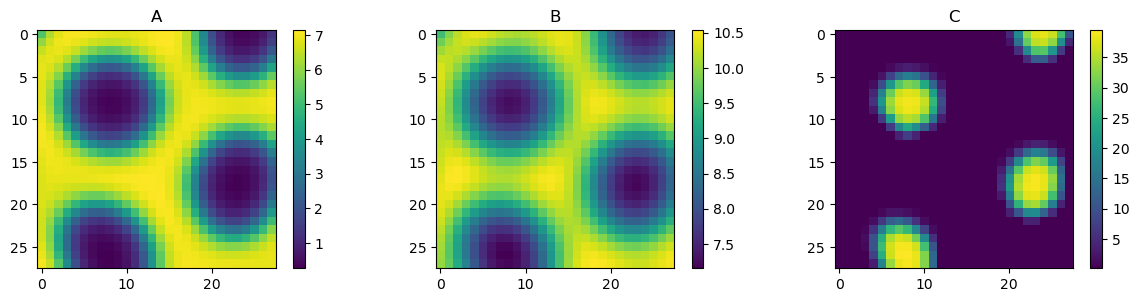

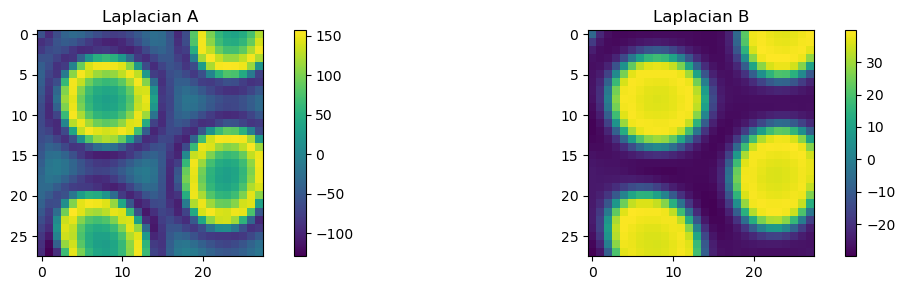

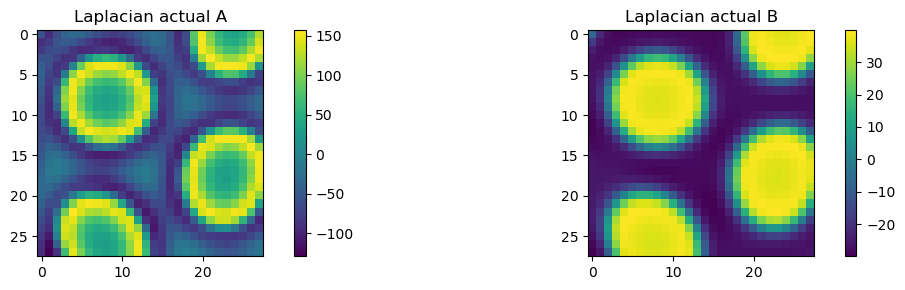

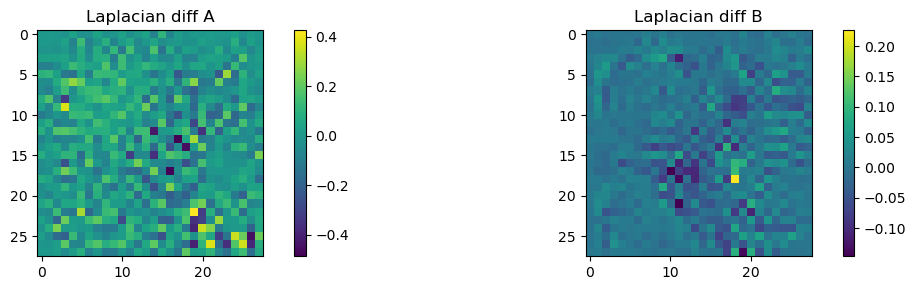

In [7]:
def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return km**n / (x**n + km**n)

physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

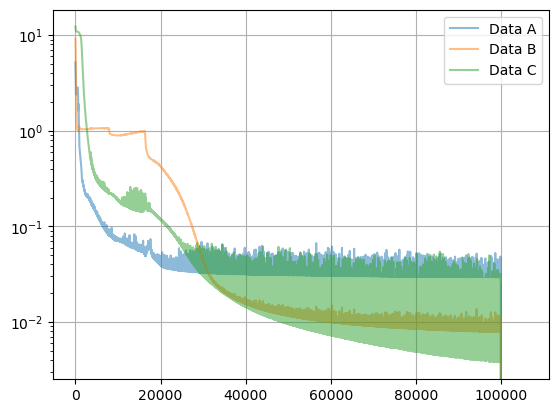

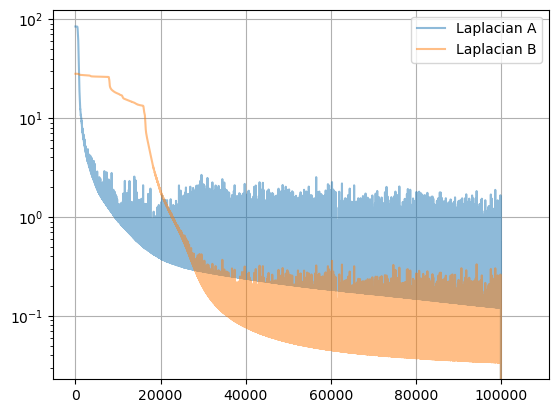

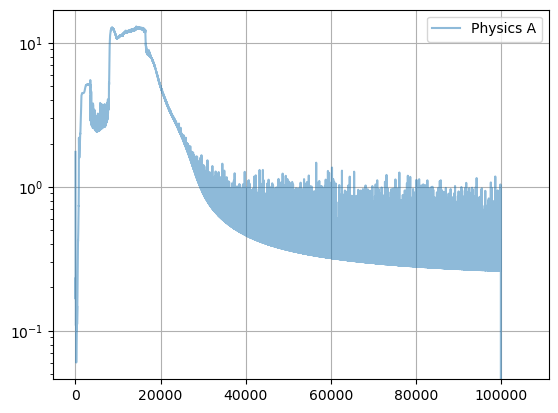

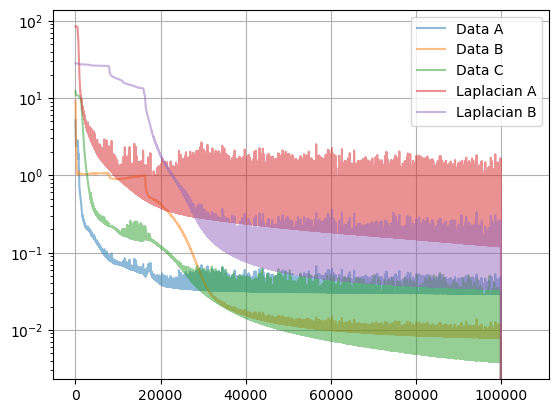

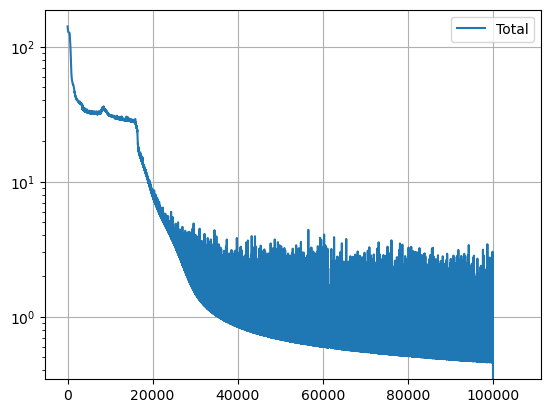

In [8]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[5,:], alpha=.5, label="Physics A")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

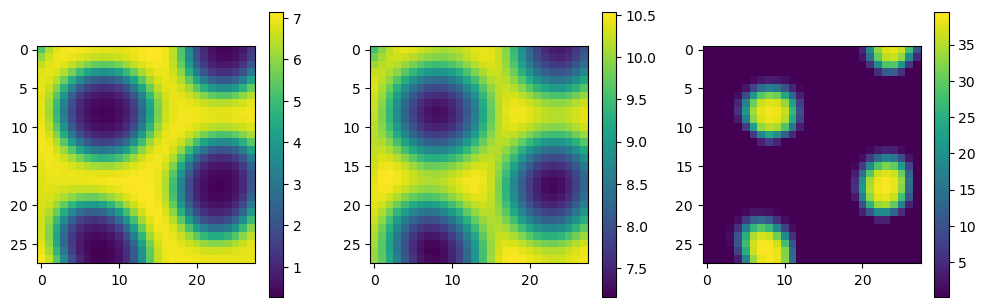

In [9]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.029636867358043145
0.008041132387307769
0.005732462092735889


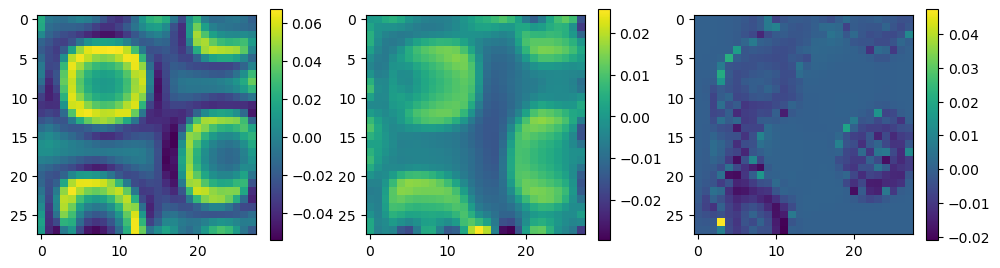

In [10]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.sqrt(np.mean((A_hat-A)**2)))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.sqrt(np.mean((B_hat-B)**2)))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.sqrt(np.mean((C_hat-C)**2)))
plt.colorbar(shrink=.75)
plt.show()


# Second optimisation
## Find the parameters

In [11]:
estimated_params = dict()
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = l.item()

In [12]:
def get_bound(name):
    if name.startswith("K"):
        return Ks_bounds[name]
    if name.startswith("n"):
        return ns_bounds[name]
    return (np.nan,np.nan)
    

def actual_by(name):
    if name.startswith("n"):
        return params["n"]
    else:
        return params[name]
print("name \tOriginl \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{actual_by(name):.3f}\t\t"                                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.008		nan		(nan,nan)
b_B:	0.100		2.026		nan		(nan,nan)
b_C:	0.100		0.040		nan		(nan,nan)
V_A:	20.000		17.856		nan		(nan,nan)
V_B:	100.000		111.656		nan		(nan,nan)
V_C:	25.000		130.873		nan		(nan,nan)
mu_A:	1.000		1.020		nan		(nan,nan)
mu_B:	5.000		5.255		nan		(nan,nan)
K_AA:	5.000		5.540		0.010		(0.010,138.245)
K_AB:	5.000		5.306		0.010		(0.010,138.245)
K_AC:	1.000		18.431		0.010		(0.010,138.245)
K_BA:	10.000		11.228		0.348		(0.348,204.701)
K_BC:	10.000		12.043		0.348		(0.348,204.701)
K_CB:	10.000		18.866		0.011		(0.011,800.166)
K_CC:	1.000		173.603		0.011		(0.011,800.166)
n_AA:	4.000		3.242		1.000		(1.000,6.000)
n_AB:	4.000		3.410		1.000		(1.000,6.000)
n_AC:	4.000		6.000		6.000		(1.000,6.000)
n_BA:	4.000		6.000		6.000		(1.000,6.000)
n_BC:	4.000		3.924		6.000		(1.000,6.000)
n_CB:	4.000		1.725		1.000		(1.000,6.000)
n_CC:	4.

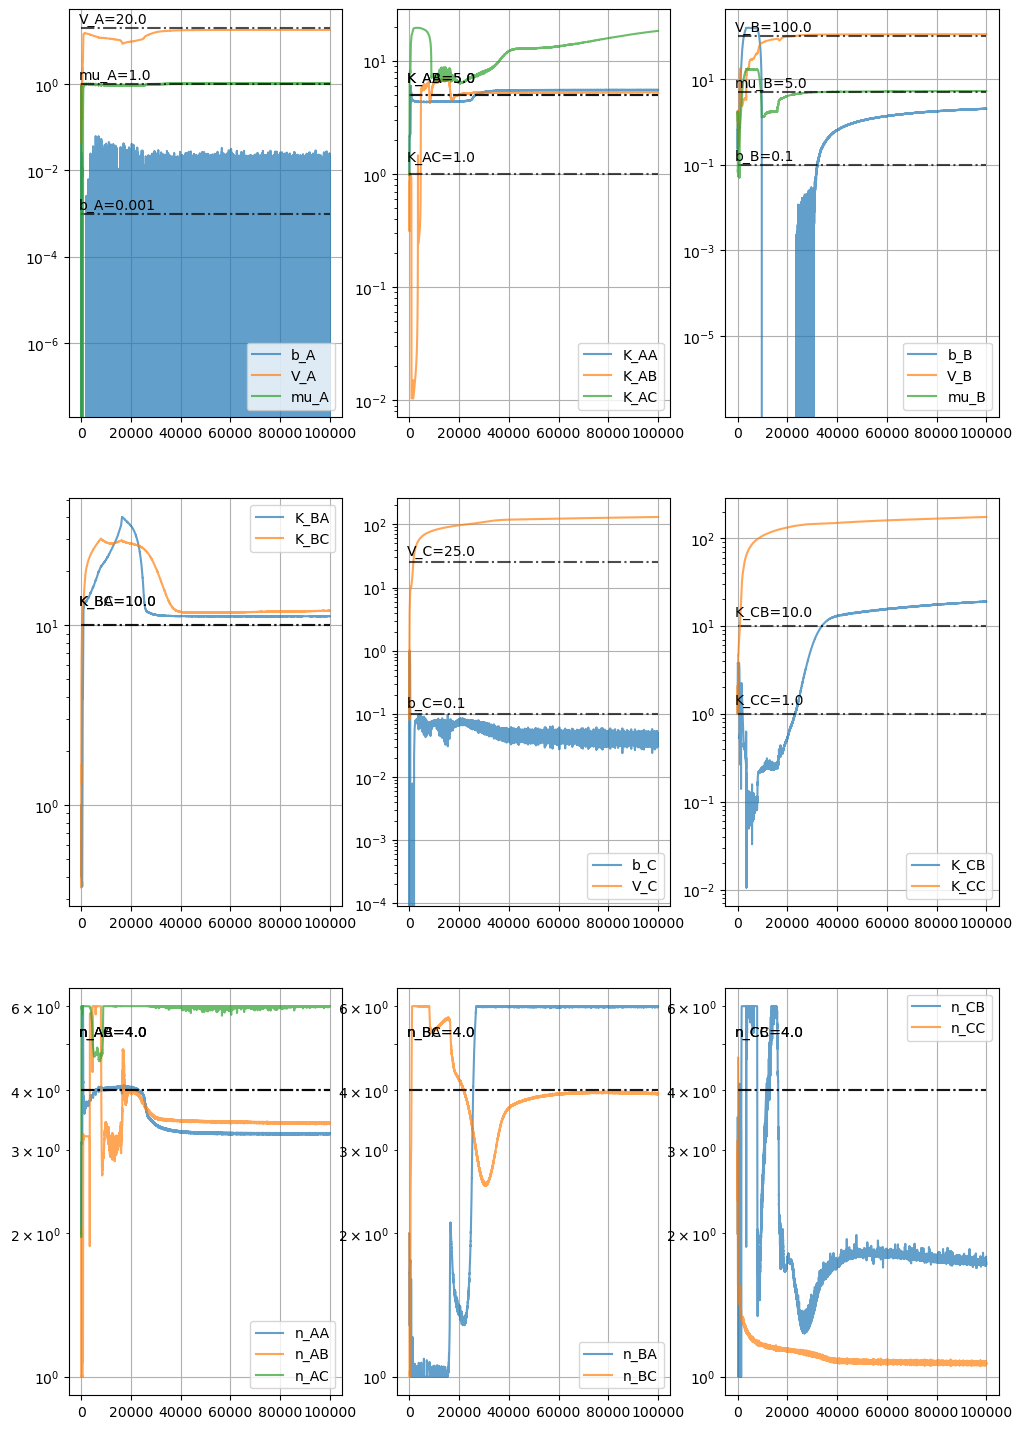

In [13]:
def plot_params(ax, names):    
    for i,(param, name) in enumerate(zip(params_list, params_name_list)):    
        if name not in names:
            continue
        ax.plot(params_sampled_list[i], label=f"{name}", alpha=.7)
        ax.hlines(actual_by(name), 0, len(params_sampled_list[i]), 
                   linestyles='-.', alpha=.7, color='black')
        ax.text(-1000, 1.3*actual_by(name), f"{name}={actual_by(name)}")
    plt.yscale('log');plt.legend();plt.grid()   
    
_ = plt.figure(figsize=(12,18))
plot_params(plt.subplot(331), ["b_A", "mu_A", "V_A"])
plot_params(plt.subplot(332), ["K_AA","K_AB","K_AC"])
plot_params(plt.subplot(333), ["b_B", "mu_B", "V_B"])
plot_params(plt.subplot(334), ["K_BA","K_BC"])
plot_params(plt.subplot(335), ["b_C", "mu_C", "V_C"])
plot_params(plt.subplot(336), ["K_CB","K_CC"])
plot_params(plt.subplot(337), ["n_AA", "n_AB", "n_AC"])
plot_params(plt.subplot(338), ["n_BA", "n_BC"])
plot_params(plt.subplot(339), ["n_CB", "n_CC"])

In [14]:
import pickle

torch.save(model, "./07_outputs/model_PINN_25")
torch.save(model.state_dict(), "./07_outputs/model_PINN_state_25")
with open('./07_outputs/model_PINN_params_name_list_25.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./07_outputs/model_PINN_losses_25.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./07_outputs/model_PINN_estimated_params_25.pkl", "wb") as f:
    pickle.dump((dict(params),  dict(estimated_params)), f)    
with open(f"./07_outputs/model_PINN_estimated_params_list_25.pkl", "wb") as f:
    pickle.dump(params_sampled_list, f)    

In [15]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , mu_C= 0.01, 1.0, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [16]:
def create_circuit_3954_2(
    b_A, mu_A, V_A, K_AA, K_AB, K_AC, b_B, mu_B, V_B, K_BA, K_BC, b_C, mu_C, V_C, K_CB, K_CC,
    n_AA, n_AB, n_AC, n_BA, n_BC, n_CB, n_CC,
):
    def circuit_3954(A, B, C):
        fA_v = b_A + V_A * act(A, K_AA, n_AA) * inh(B, K_BA, n_BA) - mu_A * A
        fB_v = b_B + V_B * act(A, K_AB, n_AB) * inh(C, K_CB, n_CB) - mu_B * B
        fC_v = b_C + V_C * inh(A, K_AC, n_AC) * inh(B, K_BC, n_BC) * act(C, K_CC, n_CC) - mu_C * C
        return (fA_v, fB_v, fC_v)
    
    return circuit_3954

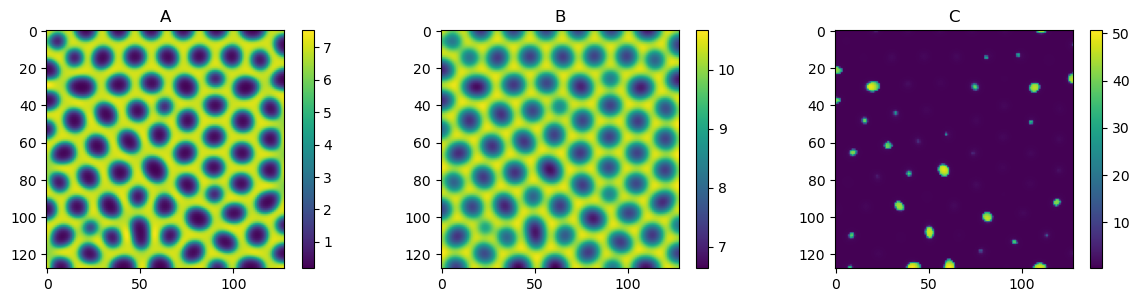

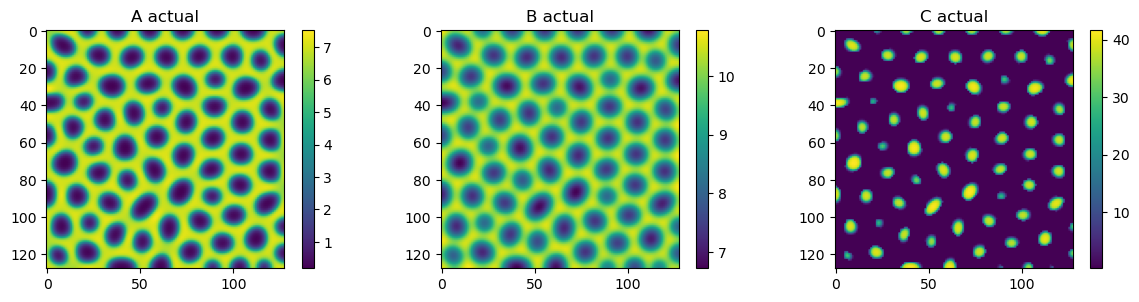

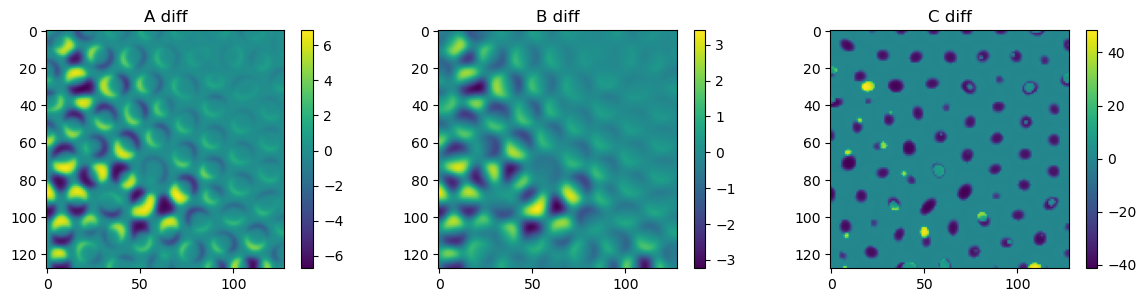

In [17]:

params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    elif k.startswith("n"):
        # Round the n to its closest integer        
        params2[k] = np.rint(v)
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954_2(params2["b_A"], params2["mu_A"], params2["V_A"], 
                                 params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                 params2["b_B"], params2["mu_B"], params2["V_B"], 
                                 params2["K_BA"], params2["K_BC"],
                                 params2["b_C"], mu_C, params2["V_C"], 
                                 params2["K_CB"], params2["K_CC"],
                                 params2["n_AA"], params2["n_AB"], params2["n_AC"],
                                 params2["n_BA"], params2["n_BC"],
                                 params2["n_CB"], params2["n_CC"],
                              )

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

In [18]:
{1:31,
2:3,
3:9, 
4:25,
5:14,
6:60,
7:24,
8:26,
9:65}

{1: 31, 2: 3, 3: 9, 4: 25, 5: 14, 6: 60, 7: 24, 8: 26, 9: 65}